In [1]:
#pip install --no-deps "git+https://github.com/pat-schmitt/oggm.git@b45b78bbfa95ed1f625c657e67393eaf89d2b72e"


In [1]:
import xarray as xr

In [3]:
xr.open_dataset('/home/www/lschuster/runs_oggm_v16/output/RGI11/run_hydro_gcm_from_2000_endyr2100__CMIP6_NorESM2-MM_ssp245_bc_2000_2019_rgi11_96_128.nc')

<xarray.Dataset>
Dimensions:                       (time: 101, rgi_id: 32, month_2d: 12)
Coordinates:
  * time                          (time) float64 2e+03 2.001e+03 ... 2.1e+03
  * rgi_id                        (rgi_id) object 'RGI60-11.00097' ... 'RGI60...
    hydro_year                    (time) int64 ...
    hydro_month                   (time) int64 ...
    calendar_year                 (time) int64 ...
    calendar_month                (time) int64 ...
  * month_2d                      (month_2d) int64 1 2 3 4 5 6 7 8 9 10 11 12
    calendar_month_2d             (time, month_2d, rgi_id) float64 ...
Data variables: (12/27)
    volume                        (time, rgi_id) float32 ...
    volume_bsl                    (time, rgi_id) float32 ...
    volume_bwl                    (time, rgi_id) float32 ...
    area                          (time, rgi_id) float32 ...
    length                        (time, rgi_id) float32 ...
    calving                       (time, rgi_id) float32 ...
    ...                            ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 ...
    snow_bucket_monthly           (time, month_2d, rgi_id) float32 ...
    residual_mb_monthly           (time, month_2d, rgi_id) float32 ...
    water_level                   (rgi_id) float32 ...
    glen_a                        (rgi_id) float32 ...
    fs                            (rgi_id) float32 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.3.2.dev394+gb45b78b
    calendar:       365-day no leap
    creation_date:  2023-04-06 18:47:05

In [1]:
import os
import logging 
import sys

# Libs
import xarray as xr
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow, tasks
from oggm.shop import gcm_climate

from func_add import run_hydro_from_2000_ref_area_2000_hist_gcm, run_hydro_from_2000_ref_area_2000_hist_w5e5

# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='ERROR')
rgi_version = '62'

cfg.PARAMS['border'] = 160 # changed for OGGM v16

# I got a strange KeyError: 'dl_verify_data_cluster.klima.uni-bremen.de' (only for RGI reg 03 and  'gfdl-esm4' 'ssp370')
cfg.PARAMS['dl_verify'] = False 
cfg.PARAMS['continue_on_error'] = True
cfg.PARAMS['use_multiprocessing']=True

# actually need to install that oggm to make it possible ...
cfg.PARAMS['store_model_geometry'] = True

2023-04-08 12:06:23: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-04-08 12:06:23: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-04-08 12:06:23: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-04-08 12:06:25: oggm.cfg: PARAMS['border'] changed from `80` to `160`.
2023-04-08 12:06:25: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2023-04-08 12:06:25: oggm.cfg: Multiprocessing switched ON after user settings.
2023-04-08 12:06:25: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


In [4]:
WORKING_DIR = utils.gettempdir(dirname='OGGM-test', reset=False)
OUTPUT_DIR = '/home/www/lschuster/runs_oggm_v16/test_output'


# Local working directory (where OGGM will write its output)
if not WORKING_DIR:
    raise RuntimeError('Need a working dir')
utils.mkdir(WORKING_DIR)
cfg.PATHS['working_dir'] = WORKING_DIR

if not OUTPUT_DIR:
    raise RuntimeError('Need an output dir')
#utils.mkdir(OUTPUT_DIR)


rgi_reg = '11' #str(sys.argv[1])
end_yr = 2100 #int(sys.argv[2]) # 2100

OGGM_GLACIER_JOB = 1 # os.environ.get('OGGM_GLACIER_JOB', '')
test = True
if test:
    n_glacier=32
else:
    n_glacier = 1000
id0 = (int(OGGM_GLACIER_JOB)-1)*n_glacier
id1 = (int(OGGM_GLACIER_JOB))*n_glacier
print(id0,id1)

0 32


In [5]:
#ls /tmp/OGGM/OGGM-test/per_glacier

In [6]:
#if rgi_reg not in ['{:02d}'.format(r) for r in range(1, 20)]:
#    raise RuntimeError('Need an RGI Region')

#gcm = str(sys.argv[1])
#ssp = str(sys.argv[2])

# Module logger
log = logging.getLogger(__name__)
log.workflow(f'Starting run for RGI reg {rgi_reg}: glaciers [{id0}:{id1}]')    

# RGI glaciers
rgi_ids = gpd.read_file(utils.get_rgi_region_file(rgi_reg, version=rgi_version))
rgi_ids = rgi_ids[id0:id1]    

# Go - get the pre-processed glacier directories
# TODO -> need to change the preprocessed directory here 
# base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.2/elev_bands/W5E5_spinup'
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.1/elev_bands/W5E5_spinup'


ALL_DIAGS = ['volume', 'volume_bsl', 'volume_bwl', 'area', 'length',  'calving', 'calving_rate'
             'off_area', 'on_area', 'melt_off_glacier',
             'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier',
             'snowfall_off_glacier', 'snowfall_on_glacier', 'model_mb',
             'residual_mb', 'snow_bucket']
# Add debug vars
cfg.PARAMS['store_diagnostic_variables'] = ALL_DIAGS

isimip3b_members = ['gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1',
                            'mri-esm2-0_r1i1p1f1',
                            'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ]
gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)

preprocess= False
if preprocess:
    gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=5, prepro_border=160,
                                              prepro_base_url=base_url, prepro_rgi_version=rgi_version)
    # preprocess climate files 
    if end_yr == 2100:
        # 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
        # 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
        
        for member in isimip3b_members:
            # Download the three main SSPs
            for ssp in ['ssp126', 'ssp370','ssp585']:
                # bias correct them
                rid = f'_ISIMIP3b_{member}_{ssp}'
                workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                                             ssp = ssp,
                                             # gcm member -> you can choose another one
                                             member=member,
                                             # recognize the climate file for later
                                             output_filesuffix=rid
                                             );
                workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                                 ssp = ssp,
                                 # gcm member -> you can choose another one
                                 member=member,
                                             year_range=('2000', '2019'),
                                             apply_bias_correction=True,
                                 # recognize the climate file for later
                                 output_filesuffix=rid+'_bc_2000_2019'
                                 );

        gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)
        # take all gcms (can't say that we only want to process 2000-2100 ....
        for gcm in gcms_cmip6.gcm.unique(): ##TEST:
            df1 = gcms_cmip6.loc[gcms_cmip6.gcm == gcm]
            for ssp in df1.ssp.unique():
                df2 = df1.loc[df1.ssp == ssp]
                assert len(df2) == 2
                ft = df2.loc[df2['var'] == 'tas'].iloc[0]
                fp = df2.loc[df2['var'] == 'pr'].iloc[0].path
                rid = ft.fname.replace('_r1i1p1f1_tas.nc', '')
                rid='_CMIP6_' + rid
                ft = ft.path

                workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                                             filesuffix=rid+'_bc_2000_2019',  # recognize the climate file for later
                                             fpath_temp=ft,  # temperature projections
                                             fpath_precip=fp,  # precip projections
                                             year_range=('2000', '2019'),
                                             );

    elif end_yr == 2300:
        gcms_cmip6 = pd.read_csv('/home/www/oggm/cmip6/all_gcm_list.csv', index_col=0)
        gcms_cmip6 = gcms_cmip6.set_index(gcms_cmip6.fname)
        # fnames that go until 2300 at the moment
        # checked via
        # gcms_cmip6_2300 = pd.read_html('/home/www/oggm/cmip6/gcm_table_2300.html')
        # needs to be updated with Rebekka's downloads
        fname_l = ['CESM2-WACCM_ssp534-over_r1i1p1f1_pr.nc', 'CESM2-WACCM_ssp534-over_r1i1p1f1_tas.nc',
                   'CESM2-WACCM_ssp585_r1i1p1f1_tas.nc', 'CESM2-WACCM_ssp585_r1i1p1f1_pr.nc',
                   'MRI-ESM2-0_ssp126_r1i1p1f1_pr.nc', 'MRI-ESM2-0_ssp126_r1i1p1f1_tas.nc',
                   'MRI-ESM2-0_ssp534-over_r1i1p1f1_pr.nc', 'MRI-ESM2-0_ssp534-over_r1i1p1f1_tas.nc',
                   'MRI-ESM2-0_ssp585_r1i1p1f1_tas.nc', 'MRI-ESM2-0_ssp585_r1i1p1f1_pr.nc'
                  ]
        gcms_cmip6 = gcms_cmip6.loc[fname_l]
        # only take those gcms that go until 2300
        for gcm in gcms_cmip6.gcm.unique(): ##TEST:
            df1 = gcms_cmip6.loc[gcms_cmip6.gcm == gcm]
            for ssp in df1.ssp.unique():
                df2 = df1.loc[df1.ssp == ssp]
                assert len(df2) == 2
                ft = df2.loc[df2['var'] == 'tas'].iloc[0]
                fp = df2.loc[df2['var'] == 'pr'].iloc[0].path
                rid = ft.fname.replace('_r1i1p1f1_tas.nc', '')
                rid='_CMIP6_' + rid
                ft = ft.path

                workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                                             filesuffix=rid+'_bc_2000_2019',  # recognize the climate file for later
                                             fpath_temp=ft,  # temperature projections
                                             fpath_precip=fp,  # precip projections
                                             year_range=('2000', '2019'),
                                             );


else:
    # use the already preprocessed stuff ...
    gdirs = workflow.init_glacier_directories(rgi_ids)


2023-04-06 19:28:09: __main__: Starting run for RGI reg 11: glaciers [0:32]
2023-04-06 19:28:10: oggm.cfg: PARAMS['store_diagnostic_variables'] changed from `['volume', 'volume_bsl', 'volume_bwl', 'area', 'length', 'calving', 'calving_rate', 'off_area', 'on_area', 'melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_off_glacier', 'snowfall_on_glacier']` to `['volume', 'volume_bsl', 'volume_bwl', 'area', 'length', 'calving', 'calving_rateoff_area', 'on_area', 'melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier', 'snowfall_off_glacier', 'snowfall_on_glacier', 'model_mb', 'residual_mb', 'snow_bucket']`.
2023-04-06 19:28:10: oggm.workflow: Execute entity tasks [GlacierDirectory] on 32 glaciers


In [7]:
# Now comes the actual run
# first using gcm from 2000-end_yr (this is how it is done in Rounce et al., 2023)
workflow.execute_entity_task(run_hydro_from_2000_ref_area_2000_hist_gcm, gdirs, end_yr = end_yr)
# then using W5E5 from 2000-2019, and GCM from 2020-end_yr (this is how it has normally be done in OGGM)
workflow.execute_entity_task(run_hydro_from_2000_ref_area_2000_hist_w5e5, gdirs, end_yr = end_yr)

2023-04-06 19:28:14: oggm.workflow: Execute entity tasks [run_hydro_from_2000_ref_area_2000_hist_gcm] on 32 glaciers
2023-04-06 19:35:46: oggm.workflow: Execute entity tasks [run_hydro_from_2000_ref_area_2000_hist_w5e5] on 32 glaciers


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [56]:
# merge data together

# compile and store run output
eq_dir = os.path.join(OUTPUT_DIR, 'RGI' + rgi_reg)
utils.mkdir(eq_dir)
if end_yr == 2100:
    for member in isimip3b_members:    
        for ssp in ['ssp126', 'ssp370', 'ssp585']:
            rid = f'_ISIMIP3b_{member}_{ssp}'
            # for W5E5 as past climate 
            utils.compile_run_output(gdirs, input_filesuffix=f'_merged_from_2000_run{rid}', 
                            path=os.path.join(eq_dir, f'run_hydro_merged_endyr2100{rid}_rgi{rgi_reg}_{id0}_{id1}.nc'))
            utils.compile_run_output(gdirs, input_filesuffix=f'_merged_from_2000_run{rid}_bc_2000_2019', 
                            path=os.path.join(eq_dir, f'run_hydro_merged_endyr2100{rid}_bc_2000_2019_rgi{rgi_reg}_{id0}_{id1}.nc'))
            # for the GCM as past climate 
            utils.compile_run_output(gdirs, input_filesuffix=f'_gcm_from_2000_run{rid}', 
                            path=os.path.join(eq_dir, f'run_hydro_gcm_from_2000_endyr2100{rid}_rgi{rgi_reg}_{id0}_{id1}.nc'))
            utils.compile_run_output(gdirs, input_filesuffix=f'_gcm_from_2000_run{rid}_bc_2000_2019', 
                            path=os.path.join(eq_dir, f'run_hydro_gcm_from_2000_endyr2100{rid}_bc_2000_2019_rgi{rgi_reg}_{id0}_{id1}.nc'))


for gcm in gcms_cmip6.gcm.unique(): 
    df1 = gcms_cmip6.loc[gcms_cmip6.gcm == gcm]
    for ssp in df1.ssp.unique():
        df2 = df1.loc[df1.ssp == ssp]
        assert len(df2) == 2
        ft = df2.loc[df2['var'] == 'tas'].iloc[0]
        rid = ft.fname.replace('_r1i1p1f1_tas.nc', '')
        rid='_CMIP6_' + rid

        utils.compile_run_output(gdirs, input_filesuffix=f'_merged_from_2000_run{rid}_endyr{end_yr}_bc_2000_2019', 
                                path=os.path.join(eq_dir, f'run_hydro_merged_endyr{end_yr}{rid}_bc_2000_2019_rgi{rgi_reg}_{id0}_{id1}.nc'))

        utils.compile_run_output(gdirs, input_filesuffix=f'_gcm_from_2000_run{rid}_endyr{end_yr}__bc_2000_2019', 
                                path=os.path.join(eq_dir, f'run_hydro_gcm_from_2000_endyr{end_yr}{rid}_bc_2000_2019_rgi{rgi_reg}_{id0}_{id1}.nc'))
        
        
    

2023-04-06 19:55:24: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-06 19:55:24: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-06 19:55:25: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-06 19:55:25: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-06 19:55:26: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-06 19:55:26: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-06 19:55:26: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-06 19:55:26: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-06 19:55:27: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-06 19:55:27: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-06 19:55:28: oggm.utils: Applying global task compile_run_output on 32 glaciers
2023-04-06 19:55:28: oggm.utils: Applying compile_run_output on 32 gdirs.
2023-04-06 19:55:29: oggm.ut

RuntimeError: Found no valid glaciers!

# Check and analyse the different runs

- before merging --> check directly on diagnostics files:

In [ ]:
%matplotlib inline

In [58]:
import seaborn as sns

- depending on the glacier, bias correction can have a more important or les important influence ... Let's later check if the sum still creates a large influence ... 

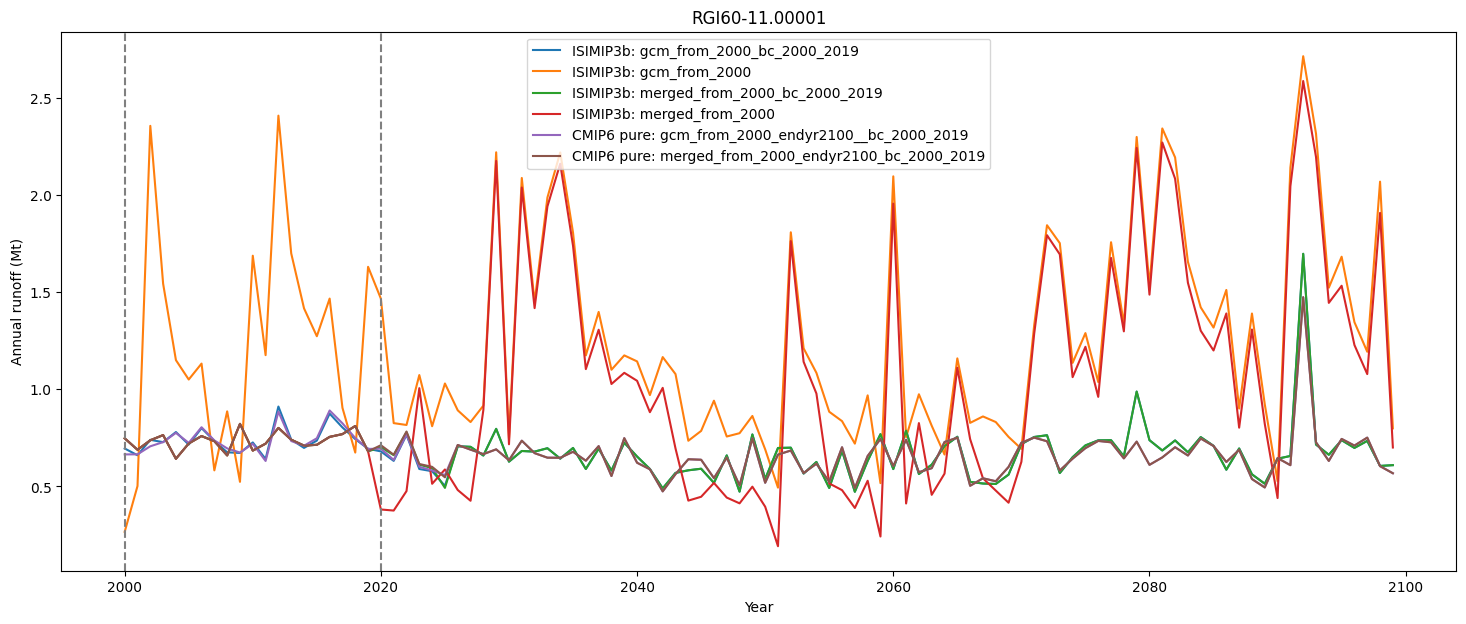

In [94]:
# Create the figure
#f, ax = plt.subplots(figsize=(18, 7)) #, sharex=True)
plt.figure(figsize=(18, 7)) 
#ax = plt.gca()
# Loop over all scenarios
file_id_l = ['_gcm_from_2000_run_ISIMIP3b_mpi-esm1-2-hr_r1i1p1f1_ssp126_bc_2000_2019',
             '_gcm_from_2000_run_ISIMIP3b_mpi-esm1-2-hr_r1i1p1f1_ssp126',
             '_merged_from_2000_run_ISIMIP3b_mpi-esm1-2-hr_r1i1p1f1_ssp126_bc_2000_2019',
             '_merged_from_2000_run_ISIMIP3b_mpi-esm1-2-hr_r1i1p1f1_ssp126',
             '_gcm_from_2000_run_CMIP6_MPI-ESM1-2-HR_ssp126_endyr2100__bc_2000_2019',
             '_merged_from_2000_run_CMIP6_MPI-ESM1-2-HR_ssp126_endyr2100_bc_2000_2019']
for i, file_id in enumerate(file_id_l):
    # Open the data, gdirs[0] correspond to Hintereisferner.
    with xr.open_dataset(gdirs[0].get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean and plot it.
    df_roll = df_runoff.sum(axis=1) #.rolling(window=11, center=True).mean()
    if i<4:
        label = 'ISIMIP3b: ' + file_id.split('_run')[0][1:] + file_id.split('ssp')[-1][3:]
    else:
         label = 'CMIP6 pure: ' + file_id.split('_run')[0][1:] + file_id.split('ssp')[-1][3:]
    plt.plot(df_roll.index.values, df_roll.values, label=label) # color=sns.color_palette("rocket")[i])

plt.ylabel('Annual runoff (Mt)'); plt.xlabel('Year'); plt.title(gdirs[0].rgi_id); 
#plt.legend()
#handles, labels = ax.get_legend_handles_labels()
plt.legend()
plt.axvline(2000, c='grey', ls='--')
plt.axvline(2020, c='grey', ls='--')
plt.show()

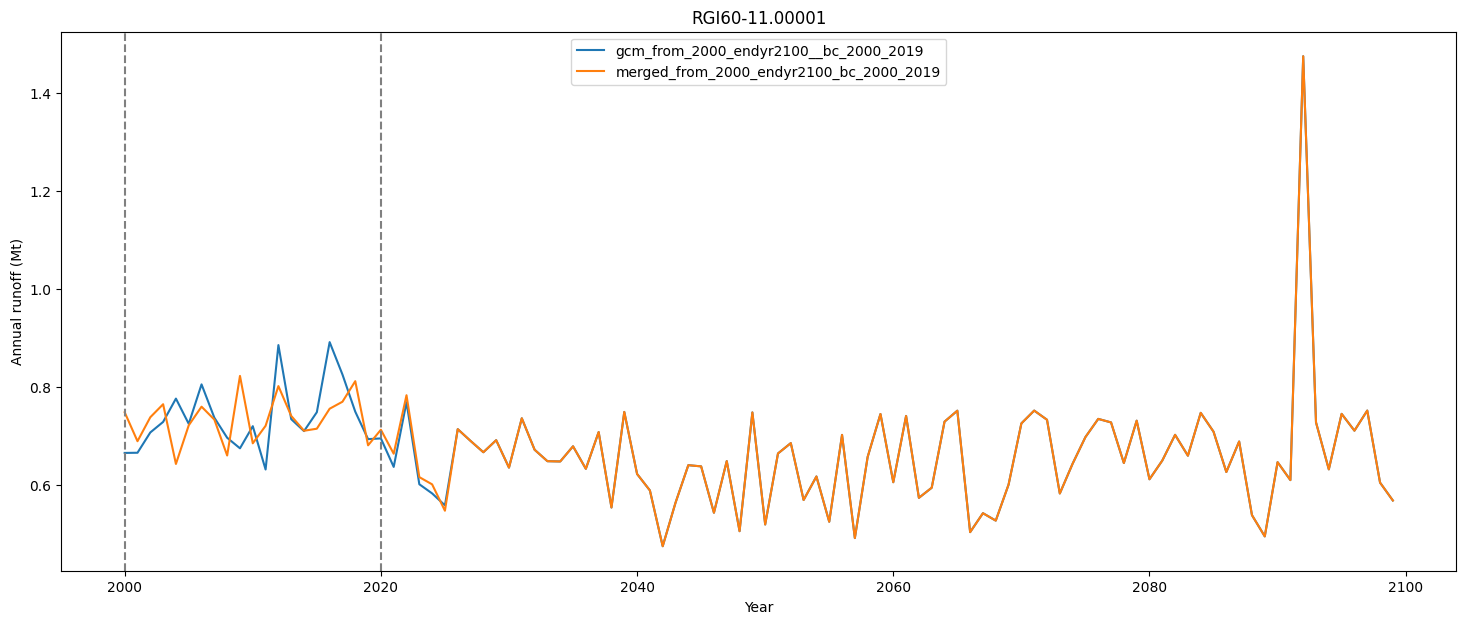

In [82]:
# Create the figure
#f, ax = plt.subplots(figsize=(18, 7)) #, sharex=True)
plt.figure(figsize=(18, 7)) 
#ax = plt.gca()
# Loop over all scenarios
file_id_l = ['_gcm_from_2000_run_CMIP6_MPI-ESM1-2-HR_ssp126_endyr2100__bc_2000_2019',
             '_merged_from_2000_run_CMIP6_MPI-ESM1-2-HR_ssp126_endyr2100_bc_2000_2019']
for i, file_id in enumerate(file_id_l):
    # Open the data, gdirs[0] correspond to Hintereisferner.
    with xr.open_dataset(gdirs[0].get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean and plot it.
    df_roll = df_runoff.sum(axis=1) #.rolling(window=11, center=True).mean()
    label = file_id.split('_run')[0][1:] + file_id.split('ssp')[-1][3:]
    plt.plot(df_roll.index.values, df_roll.values, label=label) # color=sns.color_palette("rocket")[i])

plt.ylabel('Annual runoff (Mt)'); plt.xlabel('Year'); plt.title(gdirs[0].rgi_id); 
#plt.legend()
#handles, labels = ax.get_legend_handles_labels()
plt.legend()
plt.axvline(2000, c='grey', ls='--')
plt.axvline(2020, c='grey', ls='--')
plt.show()

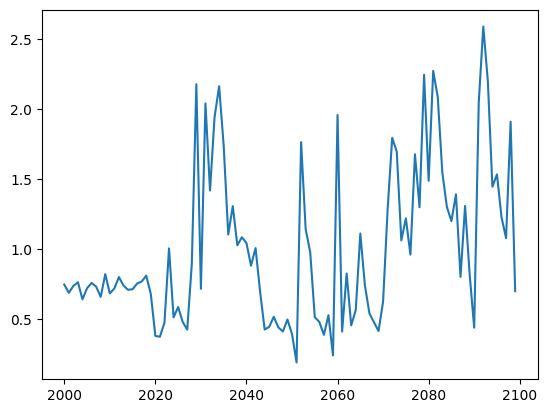

In [67]:
plt.plot(df_roll.index.values, df_roll.values) #, label=file_id)

In [61]:
df_roll.index.values

array([2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007., 2008.,
       2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016., 2017.,
       2018., 2019., 2020., 2021., 2022., 2023., 2024., 2025., 2026.,
       2027., 2028., 2029., 2030., 2031., 2032., 2033., 2034., 2035.,
       2036., 2037., 2038., 2039., 2040., 2041., 2042., 2043., 2044.,
       2045., 2046., 2047., 2048., 2049., 2050., 2051., 2052., 2053.,
       2054., 2055., 2056., 2057., 2058., 2059., 2060., 2061., 2062.,
       2063., 2064., 2065., 2066., 2067., 2068., 2069., 2070., 2071.,
       2072., 2073., 2074., 2075., 2076., 2077., 2078., 2079., 2080.,
       2081., 2082., 2083., 2084., 2085., 2086., 2087., 2088., 2089.,
       2090., 2091., 2092., 2093., 2094., 2095., 2096., 2097., 2098.,
       2099.])

In [43]:
import matplotlib

In [44]:
matplotlib.__version__

'3.5.3'

In [38]:
file_id[0]

'_'

In [23]:
labels

[]

In [17]:
handles

[]

In [ ]:
plt.plot(dt.time, dt['on_area'] + dt['off_area'])
plt.plot(dt.time.sel(time=slice(1980,2030)), dt.area_m2.sel(time=slice(1980,2030)), label=f'_merged_from_2000_run{rid}')
plt.plot(dspinup.time, dspinup.area_m2, ls= '--', label='_spinup_historical')